# **Set-up:**

These are the additional packages to be installed on the terminal:

```
pip install scikit-learn
pip install rpy2
pip install spotipy
pip install nltk
```

Run this code to install the packages required:

In [87]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from plotnine import *
import plotnine as p9
import re
from scrapy import Selector
import requests as requests
import json
import statsmodels.api as sm
import spotipy
import base64
from requests import post
from spotipy.oauth2 import SpotifyClientCredentials
from datetime import datetime
from sklearn import *
from base64 import *

# Expand Dataframe from merged YouTube Data

In [121]:
merged_df = pd.read_csv('../data/merged_new.csv')

In [122]:
merged_df.head()

,Unnamed: 0,video_id,title,channel_id,channel_title,view_count,like_count,comment_count,wikipedia_categories,duration
0,0,JGwWNGJdvx8,Ed Sheeran - Shape of You (Official Music Video),UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,6187040943,32536757.0,1150191.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT4M24S
1,1,09R8_2nJtjg,Maroon 5 - Sugar (Official Music Video),UCN1hnUccO4FD5WfM7ithXaw,Maroon5VEVO,3996606810,15982972.0,420780.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT5M2S
2,2,pRpeEdMmmQ0,Shakira - Waka Waka (This Time for Africa) (Th...,UCGnjeahCJW1AF34HBmQTJ-Q,shakiraVEVO,3840577985,22122088.0,1322022.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT3M31S
3,3,lp-EO5I60KA,Ed Sheeran - Thinking Out Loud (Official Music...,UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,3723229528,14997487.0,373089.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT4M57S
4,4,2Vv-BfVoq4g,Ed Sheeran - Perfect (Official Music Video),UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,3654497221,20738347.0,516002.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT4M40S


### Function to extract artist and song from 'title'.

In [105]:
def extract_artist_and_song(string):

    pattern_in_brackets = re.compile(r'\[.*?\]')
    pattern_in_parentheses = re.compile(r'\(.*?\)')

    string = re.sub(pattern_in_brackets, '', string)
    string = re.sub(pattern_in_parentheses, '', string)

    if '-' in string:
        artist, song = string.split('-', 1)
    else:
        return 'None'

    return [artist.strip(), song.strip()]

In [123]:
new_merge = merged_df

new_merge['Artist'] = new_merge['title'].apply(lambda x: extract_artist_and_song(x)[0])
new_merge['Song'] = new_merge['title'].apply(lambda x: extract_artist_and_song(x)[1])

new_merge.head()

,Unnamed: 0,video_id,title,channel_id,channel_title,view_count,like_count,comment_count,wikipedia_categories,duration,Artist,Song
0,0,JGwWNGJdvx8,Ed Sheeran - Shape of You (Official Music Video),UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,6187040943,32536757.0,1150191.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT4M24S,Ed Sheeran,Shape of You
1,1,09R8_2nJtjg,Maroon 5 - Sugar (Official Music Video),UCN1hnUccO4FD5WfM7ithXaw,Maroon5VEVO,3996606810,15982972.0,420780.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT5M2S,Maroon 5,Sugar
2,2,pRpeEdMmmQ0,Shakira - Waka Waka (This Time for Africa) (Th...,UCGnjeahCJW1AF34HBmQTJ-Q,shakiraVEVO,3840577985,22122088.0,1322022.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT3M31S,Shakira,Waka Waka
3,3,lp-EO5I60KA,Ed Sheeran - Thinking Out Loud (Official Music...,UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,3723229528,14997487.0,373089.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT4M57S,Ed Sheeran,Thinking Out Loud
4,4,2Vv-BfVoq4g,Ed Sheeran - Perfect (Official Music Video),UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,3654497221,20738347.0,516002.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT4M40S,Ed Sheeran,Perfect


### Funtion to generate the song URL _(this will be used for web scraping later on)_

In [109]:
def generate_song_url(song_artist, song_title):
    '''
    Returns a string of the URL for the Genius page of the song

        Parameters:
            song_artist (str): The artist of the song
            song_title (str): The title of the song

        Returns:
            song_url (str): The URL for the Genius page of the song
    '''
    
    base_url = 'https://genius.com/'
    
    # format the artist name and song title
    song_artist = song_artist.replace('&', 'and')
    formatted_artist = song_artist.lower().replace(' ', '-')
    formatted_title = song_title.lower().replace(' ', '-')
    
    # generate the song URL by concatenating strings according to Genius formatting
    song_url = f'{base_url}{formatted_artist}-{formatted_title}-lyrics'

    return song_url

In [124]:
new_merge['Genius_URL'] = new_merge.apply(lambda row: generate_song_url(row['Artist'], row['Song']), axis=1)

new_merge.head()

,Unnamed: 0,video_id,title,channel_id,channel_title,view_count,like_count,comment_count,wikipedia_categories,duration,Artist,Song,Genius_URL
0,0,JGwWNGJdvx8,Ed Sheeran - Shape of You (Official Music Video),UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,6187040943,32536757.0,1150191.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT4M24S,Ed Sheeran,Shape of You,https://genius.com/ed-sheeran-shape-of-you-lyrics
1,1,09R8_2nJtjg,Maroon 5 - Sugar (Official Music Video),UCN1hnUccO4FD5WfM7ithXaw,Maroon5VEVO,3996606810,15982972.0,420780.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT5M2S,Maroon 5,Sugar,https://genius.com/maroon-5-sugar-lyrics
2,2,pRpeEdMmmQ0,Shakira - Waka Waka (This Time for Africa) (Th...,UCGnjeahCJW1AF34HBmQTJ-Q,shakiraVEVO,3840577985,22122088.0,1322022.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT3M31S,Shakira,Waka Waka,https://genius.com/shakira-waka-waka-lyrics
3,3,lp-EO5I60KA,Ed Sheeran - Thinking Out Loud (Official Music...,UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,3723229528,14997487.0,373089.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT4M57S,Ed Sheeran,Thinking Out Loud,https://genius.com/ed-sheeran-thinking-out-lou...
4,4,2Vv-BfVoq4g,Ed Sheeran - Perfect (Official Music Video),UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,3654497221,20738347.0,516002.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT4M40S,Ed Sheeran,Perfect,https://genius.com/ed-sheeran-perfect-lyrics


### Function to scrape the lyrics based on the URL

In [111]:
def scrape_lyrics(session, song_url):
    '''
    Returns a string of song lyrics, with each line separated by a new line

        Parameters:
            session (variable): The session that has been initialised for requesting from the Genius website
            song_url (str): The URL of the Genius page for the song

        Returns:
            lyrics (str): The lyrics of the song
    '''
    
    # use initialised session to enhance performance
    response = session.get(song_url)
    sel = Selector(text=response.text)
    
    # scrape lyrics into one large string
    raw_lyrics = ' '.join(sel.css('div.Lyrics__Container-sc-1ynbvzw-1.kUgSbL ::text').getall())

    # clean lyrics using regular expression to remove words in square brackets
    pattern = r'\[.*?\]'
    result_string = re.sub(pattern, '', raw_lyrics)
    lyrics = ' '.join(result_string.split())

    return lyrics

In [112]:
credentials_file_path = "../credentials.json"

with open(credentials_file_path, "r") as f:
    credentials = json.load(f)

In [113]:
my_session = requests.Session()

### Under 'wikipedia_categories', there are separate links for different potential genres

We have noticed that:
* Each link is separated by a comma ','
* Every song has at least one category – 'music'
* Some songs are in multiple categories, majority of them only has only one, some has two, songs with two and more categories are extremely rare

Therefore, we can count the number of commas to determine the number of categories, with the function as such:

In [145]:
def get_category_number(x):
    string = str(x)
    return string.count(',')

In [149]:
new_merge['category_number'] = new_merge['wikipedia_categories'].apply(lambda x: get_category_number(x))

In [151]:
new_merge.head()

,Unnamed: 0,video_id,title,channel_id,channel_title,view_count,like_count,comment_count,wikipedia_categories,duration,Artist,Song,Genius_URL,category_number
0,0,JGwWNGJdvx8,Ed Sheeran - Shape of You (Official Music Video),UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,6187040943,32536757.0,1150191.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT4M24S,Ed Sheeran,Shape of You,https://genius.com/ed-sheeran-shape-of-you-lyrics,1
1,1,09R8_2nJtjg,Maroon 5 - Sugar (Official Music Video),UCN1hnUccO4FD5WfM7ithXaw,Maroon5VEVO,3996606810,15982972.0,420780.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT5M2S,Maroon 5,Sugar,https://genius.com/maroon-5-sugar-lyrics,1
2,2,pRpeEdMmmQ0,Shakira - Waka Waka (This Time for Africa) (Th...,UCGnjeahCJW1AF34HBmQTJ-Q,shakiraVEVO,3840577985,22122088.0,1322022.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT3M31S,Shakira,Waka Waka,https://genius.com/shakira-waka-waka-lyrics,2
3,3,lp-EO5I60KA,Ed Sheeran - Thinking Out Loud (Official Music...,UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,3723229528,14997487.0,373089.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT4M57S,Ed Sheeran,Thinking Out Loud,https://genius.com/ed-sheeran-thinking-out-lou...,1
4,4,2Vv-BfVoq4g,Ed Sheeran - Perfect (Official Music Video),UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,3654497221,20738347.0,516002.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT4M40S,Ed Sheeran,Perfect,https://genius.com/ed-sheeran-perfect-lyrics,1


In [159]:
new_merge2 = new_merge.head(150)

In [160]:
new_merge2['lyrics'] = new_merge2.apply(lambda row: scrape_lyrics(my_session, row['Genius_URL']), axis=1)

new_merge2.head()

/var/folders/n2/rv87rvcx08s9hsq8cmkrj79h0000gn/T/ipykernel_63764/3335602031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,video_id,title,channel_id,channel_title,view_count,like_count,comment_count,wikipedia_categories,duration,Artist,Song,Genius_URL,category_number,lyrics
0,0,JGwWNGJdvx8,Ed Sheeran - Shape of You (Official Music Video),UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,6187040943,32536757.0,1150191.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT4M24S,Ed Sheeran,Shape of You,https://genius.com/ed-sheeran-shape-of-you-lyrics,1,A club isn't the best place to find a lover So...
1,1,09R8_2nJtjg,Maroon 5 - Sugar (Official Music Video),UCN1hnUccO4FD5WfM7ithXaw,Maroon5VEVO,3996606810,15982972.0,420780.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT5M2S,Maroon 5,Sugar,https://genius.com/maroon-5-sugar-lyrics,1,"I'm hurting, baby, I'm broken down I need your..."
2,2,pRpeEdMmmQ0,Shakira - Waka Waka (This Time for Africa) (Th...,UCGnjeahCJW1AF34HBmQTJ-Q,shakiraVEVO,3840577985,22122088.0,1322022.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT3M31S,Shakira,Waka Waka,https://genius.com/shakira-waka-waka-lyrics,2,
3,3,lp-EO5I60KA,Ed Sheeran - Thinking Out Loud (Official Music...,UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,3723229528,14997487.0,373089.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT4M57S,Ed Sheeran,Thinking Out Loud,https://genius.com/ed-sheeran-thinking-out-lou...,1,When your legs don't work like they used to be...
4,4,2Vv-BfVoq4g,Ed Sheeran - Perfect (Official Music Video),UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,3654497221,20738347.0,516002.0,"['https://en.wikipedia.org/wiki/Music', 'https...",PT4M40S,Ed Sheeran,Perfect,https://genius.com/ed-sheeran-perfect-lyrics,1,"I found a love for me Oh, darlin', just dive r..."


# Clean and Analyse Data

### We create a new dataframe with the necessary headers only, removing 'None' values or duplicates

In [165]:
new_merge3 = new_merge2.dropna()

df = new_merge3[['Artist', 'Song', 'like_count', 'view_count', 'comment_count', 'lyrics', 'category_number']].dropna().drop_duplicates(subset = ['Song'])

df = df[df['lyrics'] != '']

df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics,category_number
0,Ed Sheeran,Shape of You,32536757.0,6187040943,1150191.0,A club isn't the best place to find a lover So...,1
1,Maroon 5,Sugar,15982972.0,3996606810,420780.0,"I'm hurting, baby, I'm broken down I need your...",1
3,Ed Sheeran,Thinking Out Loud,14997487.0,3723229528,373089.0,When your legs don't work like they used to be...,1
4,Ed Sheeran,Perfect,20738347.0,3654497221,516002.0,"I found a love for me Oh, darlin', just dive r...",1
7,Adele,Hello,18701599.0,3120953502,946820.0,"Hello, it's me I was wondering if, after all t...",2


### Imported package to analyse sentiments

We create function and apply it to dataframe|

In [167]:
sid = SentimentIntensityAnalyzer()

def get_sentiment_score(lyric):
    scores = sid.polarity_scores(lyric)
    list = [scores['neg'], scores['neu'], scores['pos'], scores['compound']]
    return list

In [168]:
df['sentiment_positive'] = df['lyrics'].apply(lambda x: get_sentiment_score(x)[2])
df['sentiment_neutral'] = df['lyrics'].apply(lambda x: get_sentiment_score(x)[1])
df['sentiment_negative'] = df['lyrics'].apply(lambda x: get_sentiment_score(x)[0])
df['sentiment_compound'] = df['lyrics'].apply(lambda x: get_sentiment_score(x)[3])

df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics,category_number,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound
0,Ed Sheeran,Shape of You,32536757.0,6187040943,1150191.0,A club isn't the best place to find a lover So...,1,0.229,0.757,0.014,0.9995
1,Maroon 5,Sugar,15982972.0,3996606810,420780.0,"I'm hurting, baby, I'm broken down I need your...",1,0.288,0.642,0.070,0.9988
3,Ed Sheeran,Thinking Out Loud,14997487.0,3723229528,373089.0,When your legs don't work like they used to be...,1,0.188,0.789,0.023,0.9967
4,Ed Sheeran,Perfect,20738347.0,3654497221,516002.0,"I found a love for me Oh, darlin', just dive r...",1,0.251,0.700,0.049,0.9974
7,Adele,Hello,18701599.0,3120953502,946820.0,"Hello, it's me I was wondering if, after all t...",2,0.033,0.826,0.141,-0.9789


### We define lexical richness as the proportion of unique words to total words used, a quantitative way to analyse the richness of vocabulary used in a song. Using function below:

In [169]:
def get_lexical_richness(lyric):
    total_words = len(lyric.split())
    unique_words = len(set(lyric.split()))
    lexical_richness = unique_words/total_words*100
    return round(lexical_richness)

In [170]:
df['lexical_richness'] = df['lyrics'].apply(lambda x: get_lexical_richness(x))

df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics,category_number,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness
0,Ed Sheeran,Shape of You,32536757.0,6187040943,1150191.0,A club isn't the best place to find a lover So...,1,0.229,0.757,0.014,0.9995,23
1,Maroon 5,Sugar,15982972.0,3996606810,420780.0,"I'm hurting, baby, I'm broken down I need your...",1,0.288,0.642,0.070,0.9988,29
3,Ed Sheeran,Thinking Out Loud,14997487.0,3723229528,373089.0,When your legs don't work like they used to be...,1,0.188,0.789,0.023,0.9967,44
4,Ed Sheeran,Perfect,20738347.0,3654497221,516002.0,"I found a love for me Oh, darlin', just dive r...",1,0.251,0.700,0.049,0.9974,52
7,Adele,Hello,18701599.0,3120953502,946820.0,"Hello, it's me I was wondering if, after all t...",2,0.033,0.826,0.141,-0.9789,38


### Find song length as well

In [171]:
df['song_length'] = df['lyrics'].apply(lambda x: len(x.split()))

df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics,category_number,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness,song_length
0,Ed Sheeran,Shape of You,32536757.0,6187040943,1150191.0,A club isn't the best place to find a lover So...,1,0.229,0.757,0.014,0.9995,23,699
1,Maroon 5,Sugar,15982972.0,3996606810,420780.0,"I'm hurting, baby, I'm broken down I need your...",1,0.288,0.642,0.070,0.9988,29,472
3,Ed Sheeran,Thinking Out Loud,14997487.0,3723229528,373089.0,When your legs don't work like they used to be...,1,0.188,0.789,0.023,0.9967,44,326
4,Ed Sheeran,Perfect,20738347.0,3654497221,516002.0,"I found a love for me Oh, darlin', just dive r...",1,0.251,0.700,0.049,0.9974,52,297
7,Adele,Hello,18701599.0,3120953502,946820.0,"Hello, it's me I was wondering if, after all t...",2,0.033,0.826,0.141,-0.9789,38,365


In [172]:
df['sentiment_compound_absolute'] = df['sentiment_compound'].abs()

df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics,category_number,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness,song_length,sentiment_compound_absolute
0,Ed Sheeran,Shape of You,32536757.0,6187040943,1150191.0,A club isn't the best place to find a lover So...,1,0.229,0.757,0.014,0.9995,23,699,0.9995
1,Maroon 5,Sugar,15982972.0,3996606810,420780.0,"I'm hurting, baby, I'm broken down I need your...",1,0.288,0.642,0.070,0.9988,29,472,0.9988
3,Ed Sheeran,Thinking Out Loud,14997487.0,3723229528,373089.0,When your legs don't work like they used to be...,1,0.188,0.789,0.023,0.9967,44,326,0.9967
4,Ed Sheeran,Perfect,20738347.0,3654497221,516002.0,"I found a love for me Oh, darlin', just dive r...",1,0.251,0.700,0.049,0.9974,52,297,0.9974
7,Adele,Hello,18701599.0,3120953502,946820.0,"Hello, it's me I was wondering if, after all t...",2,0.033,0.826,0.141,-0.9789,38,365,0.9789


# Integrate Spotify API

Lastly, we integrate spotify API as well to find even more categories

In [174]:
client_id = credentials['client_id']
client_secret = credentials['client_secret']

client_creds = f"{client_id}:{client_secret}"
base64_client_creds = b64encode(client_creds.encode()).decode()

auth_url = 'https://accounts.spotify.com/api/token'
headers = {
    'Authorization': f'Basic {base64_client_creds}'
}
payload = {
    'grant_type': 'client_credentials'
}

response = requests.post(auth_url, headers=headers, data=payload)

response.json()


{'access_token': 'BQAnGpyIkcZeIHCMnk9kUzgvwUzG-sCTycOqPv-8Oq5hIHJx0NUpfJVLDH-JBaAhj580O0SxZYQyPEcmNUAlOZ37ZyyPqyWC9A_JYljo_hc45UI-Swk',
 'token_type': 'Bearer',
 'expires_in': 3600}

### Using 'spotipy' package and the search() function, we are able to get data in the json file such as release date, a popularity score, whether the song is explicit, and the number of markets that the song is in during its initial release

In [175]:
def get_release_date(song):
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    result = sp.search(song)
    release_date = result['tracks']['items'][0]['album']['release_date']
    return release_date

In [176]:
def get_popularity(song):
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    result = sp.search(song)
    popularity = result['tracks']['items'][0]['popularity']
    return popularity

In [177]:
def get_explicitness(song):
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    result = sp.search(song)
    explicitness = result['tracks']['items'][0]['explicit']
    return explicitness

In [178]:
def get_market_number(song):
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    result = sp.search(song)
    available_markets = result['tracks']['items'][0]['available_markets']
    return len(available_markets)

### Integrating these into our existing dataframe:

In [179]:
df['release_date'] = df['Song'].apply(lambda x: get_release_date(x))
df['popularity'] = df['Song'].apply(lambda x: get_popularity(x))
df['explicitness'] = df['Song'].apply(lambda x: get_explicitness(x))
df['markets'] = df['Song'].apply(lambda x: get_market_number(x))

### We want to convert our date to datetime format for ease of plotting later on

In [183]:
def convert_date(x):
    try:
        pd.to_datetime(x)
        return pd.to_datetime(x)
    except:
        None
        return None

In [184]:
df['release_date'] = df['release_date'].apply(lambda x: convert_date(x)).dropna()
# df['release_date'] = pd.to_datetime(df['release_date'])
df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics,category_number,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness,song_length,sentiment_compound_absolute,release_date,popularity,explicitness,markets
0,Ed Sheeran,Shape of You,32536757.0,6187040943,1150191.0,A club isn't the best place to find a lover So...,1,0.229,0.757,0.014,0.9995,23,699,0.9995,2017-03-03,89,False,184
1,Maroon 5,Sugar,15982972.0,3996606810,420780.0,"I'm hurting, baby, I'm broken down I need your...",1,0.288,0.642,0.070,0.9988,29,472,0.9988,2020-08-25,73,True,184
3,Ed Sheeran,Thinking Out Loud,14997487.0,3723229528,373089.0,When your legs don't work like they used to be...,1,0.188,0.789,0.023,0.9967,44,326,0.9967,2014-06-21,85,False,162
4,Ed Sheeran,Perfect,20738347.0,3654497221,516002.0,"I found a love for me Oh, darlin', just dive r...",1,0.251,0.700,0.049,0.9974,52,297,0.9974,2017-03-03,90,False,184
7,Adele,Hello,18701599.0,3120953502,946820.0,"Hello, it's me I was wondering if, after all t...",2,0.033,0.826,0.141,-0.9789,38,365,0.9789,2015-11-20,76,False,22


### For the number of markets of song release, we found some interesting facts:

For an initial release of song, it is in either:
* all 184 markets in the world
* slightly less than 184 markets (a sign that there are some censorship in some countries, a hint that the song may be culturally inappropriate/politically sensitive)
* or very little markets (<50) (a sign that the song is deliberately only released in some markets, targeting niche categories)

Hence justifying the below function, categorising them into high, medium, or low level of outreach

In [186]:
def market_availability_category(x):
    number = int(x)
    if number == 184:
        return 'High'
    elif 50 < number < 184:
        return 'Medium'
    else:
        return 'Low'

In [187]:
df['markets'] = df['markets'].apply(lambda x: market_availability_category(x))
df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics,category_number,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness,song_length,sentiment_compound_absolute,release_date,popularity,explicitness,markets
0,Ed Sheeran,Shape of You,32536757.0,6187040943,1150191.0,A club isn't the best place to find a lover So...,1,0.229,0.757,0.014,0.9995,23,699,0.9995,2017-03-03,89,False,High
1,Maroon 5,Sugar,15982972.0,3996606810,420780.0,"I'm hurting, baby, I'm broken down I need your...",1,0.288,0.642,0.070,0.9988,29,472,0.9988,2020-08-25,73,True,High
3,Ed Sheeran,Thinking Out Loud,14997487.0,3723229528,373089.0,When your legs don't work like they used to be...,1,0.188,0.789,0.023,0.9967,44,326,0.9967,2014-06-21,85,False,Medium
4,Ed Sheeran,Perfect,20738347.0,3654497221,516002.0,"I found a love for me Oh, darlin', just dive r...",1,0.251,0.700,0.049,0.9974,52,297,0.9974,2017-03-03,90,False,High
7,Adele,Hello,18701599.0,3120953502,946820.0,"Hello, it's me I was wondering if, after all t...",2,0.033,0.826,0.141,-0.9789,38,365,0.9789,2015-11-20,76,False,Low


### Similarly, for song categories:

We initially attempted to obtain song genres via YouTube, Genius or Spotify. However, we faced significant difficulties due to the fact that:
* The data is not explicitly available – these platforms offer limited sources of data to public due to privacy reasons
* It is very difficult to 

Therefore, we enlisted Wikipedia, an open source, to find out on the song genre/category. However, due to the limited amount of categorisations there are on Wikipedia, we focus on the number of categories, i.e. number of wikipedia pages they occur instead.
* Most songs do not belong to a 

In [195]:
def category_popularity(x):
    number = int(x)
    if number == 1:
        return 'Low'
    elif number == 2:
        return 'Medium'
    else:
        return 'High'

In [196]:
df['category_number'] = df['category_number'].apply(lambda x: category_popularity(x))
df.head()

,Artist,Song,like_count,view_count,comment_count,lyrics,category_number,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_compound,lexical_richness,song_length,sentiment_compound_absolute,release_date,popularity,explicitness,markets
0,Ed Sheeran,Shape of You,32536757.0,6187040943,1150191.0,A club isn't the best place to find a lover So...,Low,0.229,0.757,0.014,0.9995,23,699,0.9995,2017-03-03,89,False,High
1,Maroon 5,Sugar,15982972.0,3996606810,420780.0,"I'm hurting, baby, I'm broken down I need your...",Low,0.288,0.642,0.070,0.9988,29,472,0.9988,2020-08-25,73,True,High
3,Ed Sheeran,Thinking Out Loud,14997487.0,3723229528,373089.0,When your legs don't work like they used to be...,Low,0.188,0.789,0.023,0.9967,44,326,0.9967,2014-06-21,85,False,Medium
4,Ed Sheeran,Perfect,20738347.0,3654497221,516002.0,"I found a love for me Oh, darlin', just dive r...",Low,0.251,0.700,0.049,0.9974,52,297,0.9974,2017-03-03,90,False,High
7,Adele,Hello,18701599.0,3120953502,946820.0,"Hello, it's me I was wondering if, after all t...",Medium,0.033,0.826,0.141,-0.9789,38,365,0.9789,2015-11-20,76,False,Low


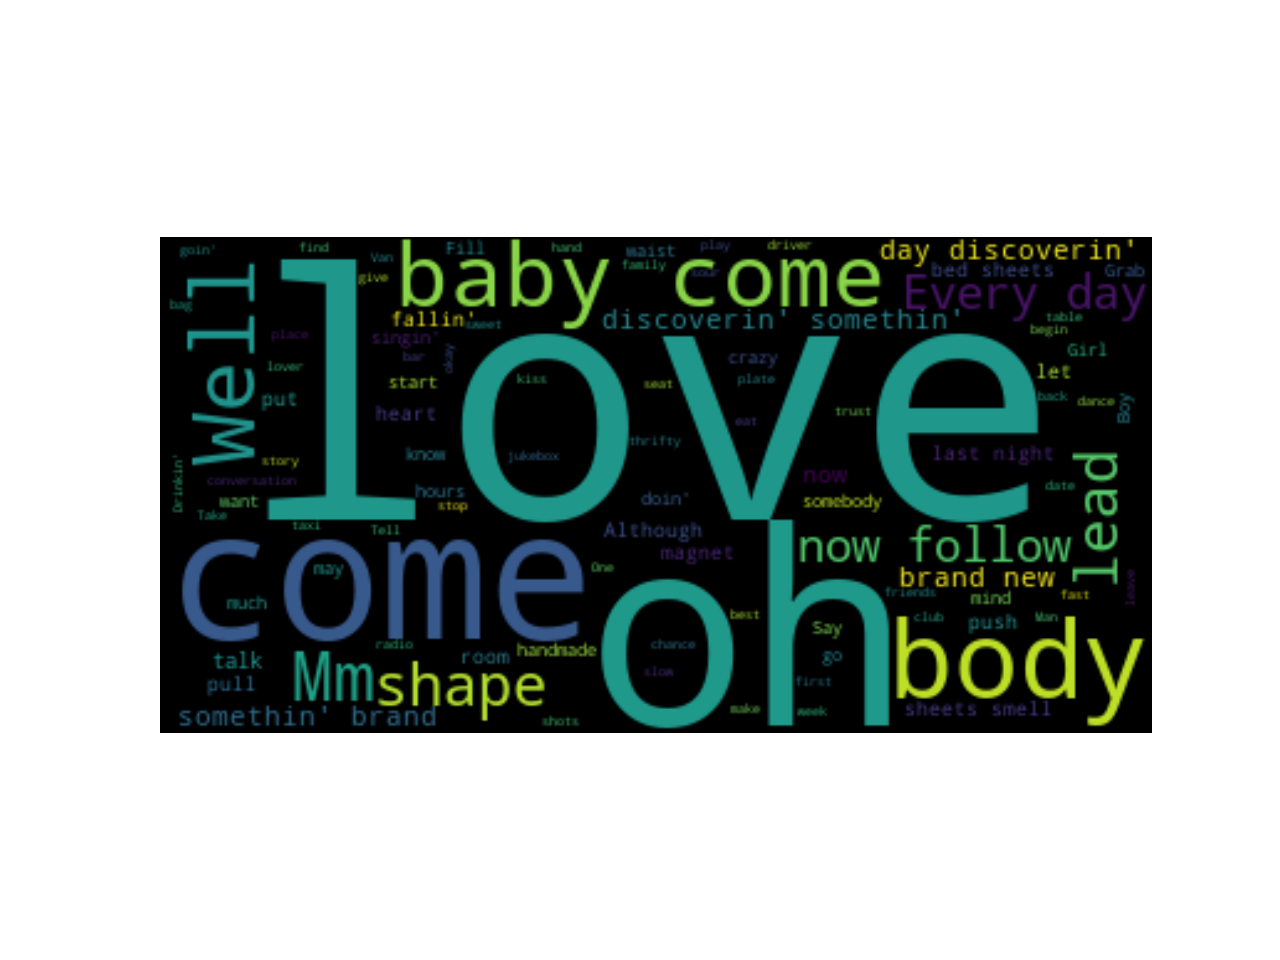

In [232]:
wordcloud = WordCloud().generate(df.iloc[0,5])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [197]:
corr_df = df[['like_count','view_count','comment_count', 'sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'sentiment_compound_absolute', 'lexical_richness', 'song_length', 'popularity']].corr()

In [198]:
corr_df2 = corr_df. \
        melt(ignore_index=False) \
        .reset_index()

corr_df2['rounded_value'] = corr_df2['value'].apply(lambda x: np.round(x, 2))

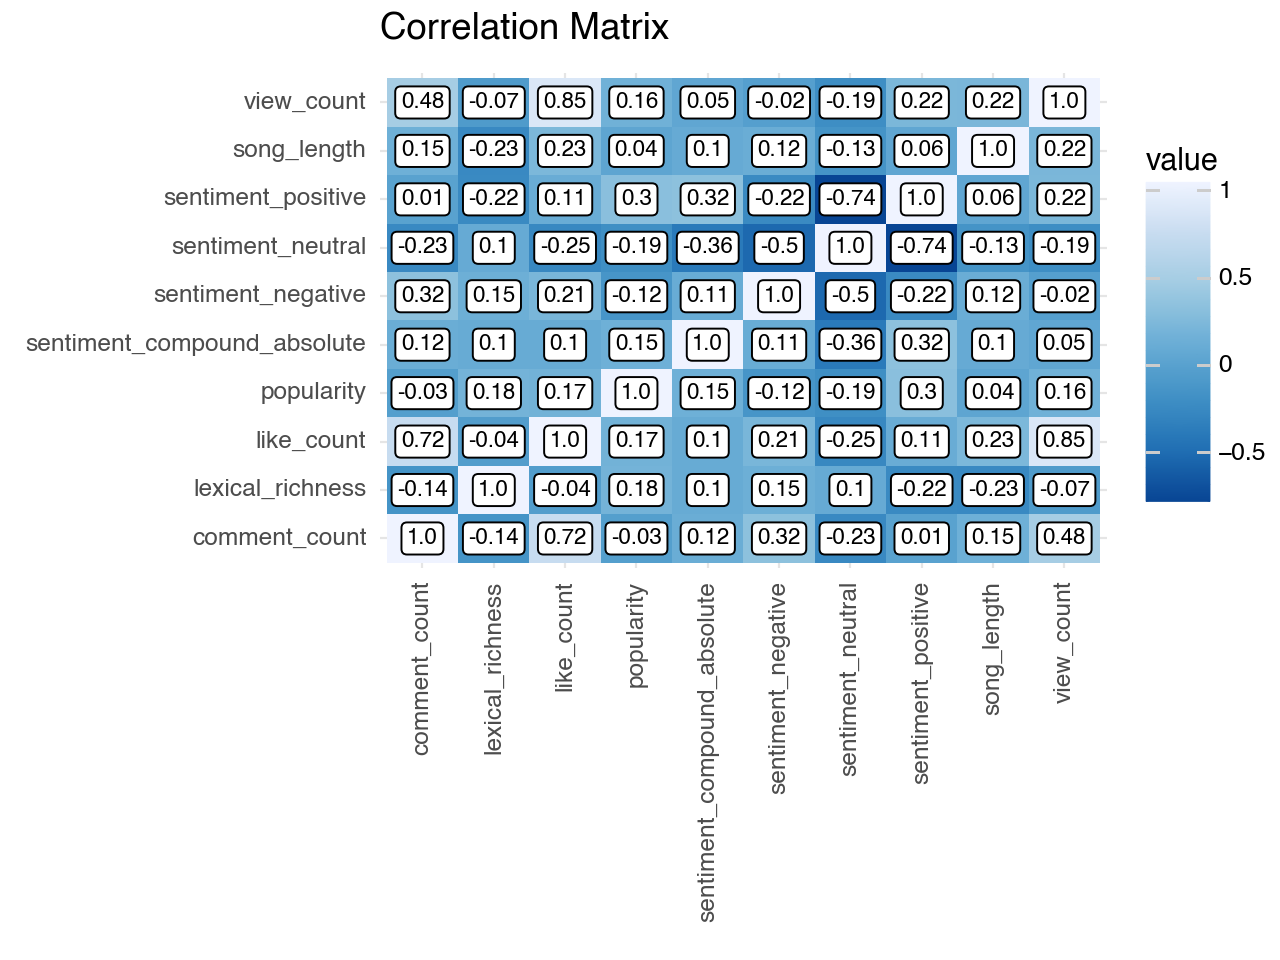

<Figure Size: (640 x 480)>

In [199]:
g = p9.ggplot(
        mapping = p9.aes('index', 'variable', fill = 'value'),
        data = corr_df2
    ) + \
        p9.geom_tile() + \
        p9.geom_label(
            p9.aes(label = 'rounded_value'),
            fill = 'white',
            size = 8
        ) + \
        p9.scale_fill_distiller() + \
        p9.theme_minimal() + \
        p9.labs(
            title = 'Correlation Matrix',
            x = '',
            y = ''
        ) + \
        p9.theme(
            axis_text_x = element_text(angle = 90)
        )

g

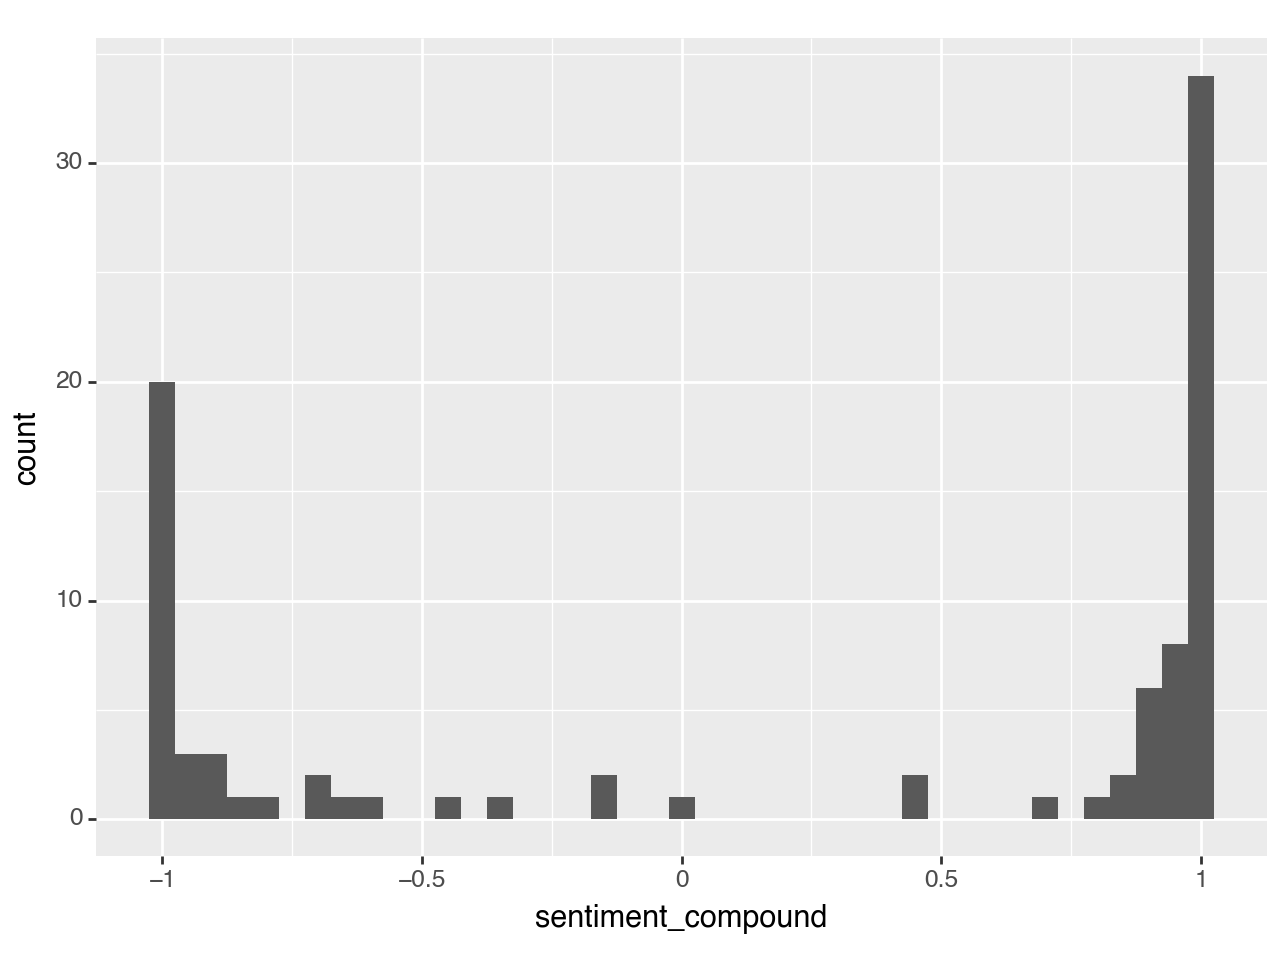

<Figure Size: (640 x 480)>

In [200]:
hist = p9.ggplot(
    mapping = p9.aes(x = 'sentiment_compound'),
    data = df
) + \
geom_histogram(binwidth=0.05)

hist

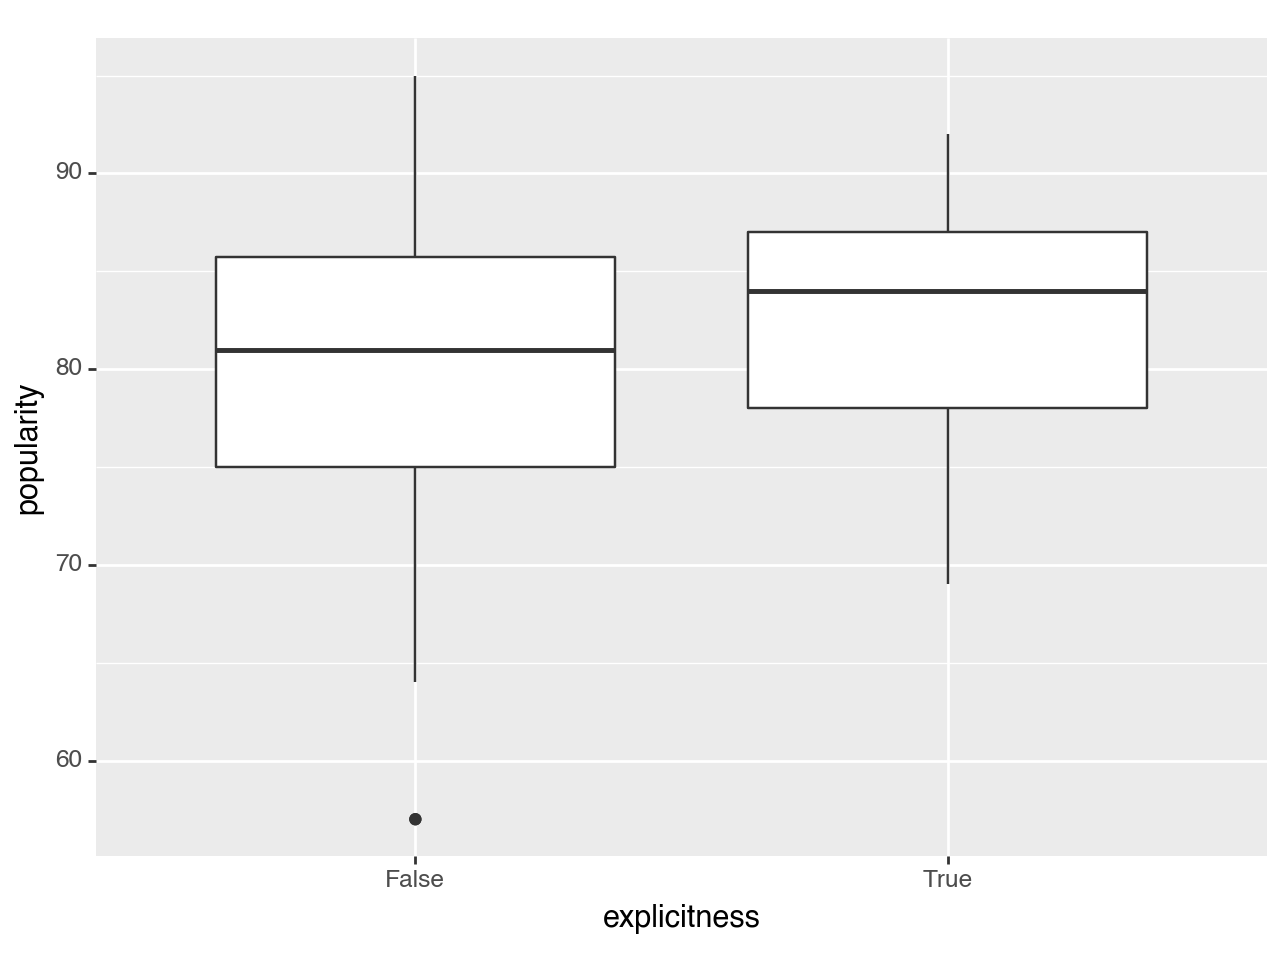

<Figure Size: (640 x 480)>

In [202]:
boxplot = (
    ggplot(df) +
    aes(x = 'explicitness', y = 'popularity') +
    geom_boxplot()
)

boxplot

/Users/ruka/miniconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 11 rows containing missing values.


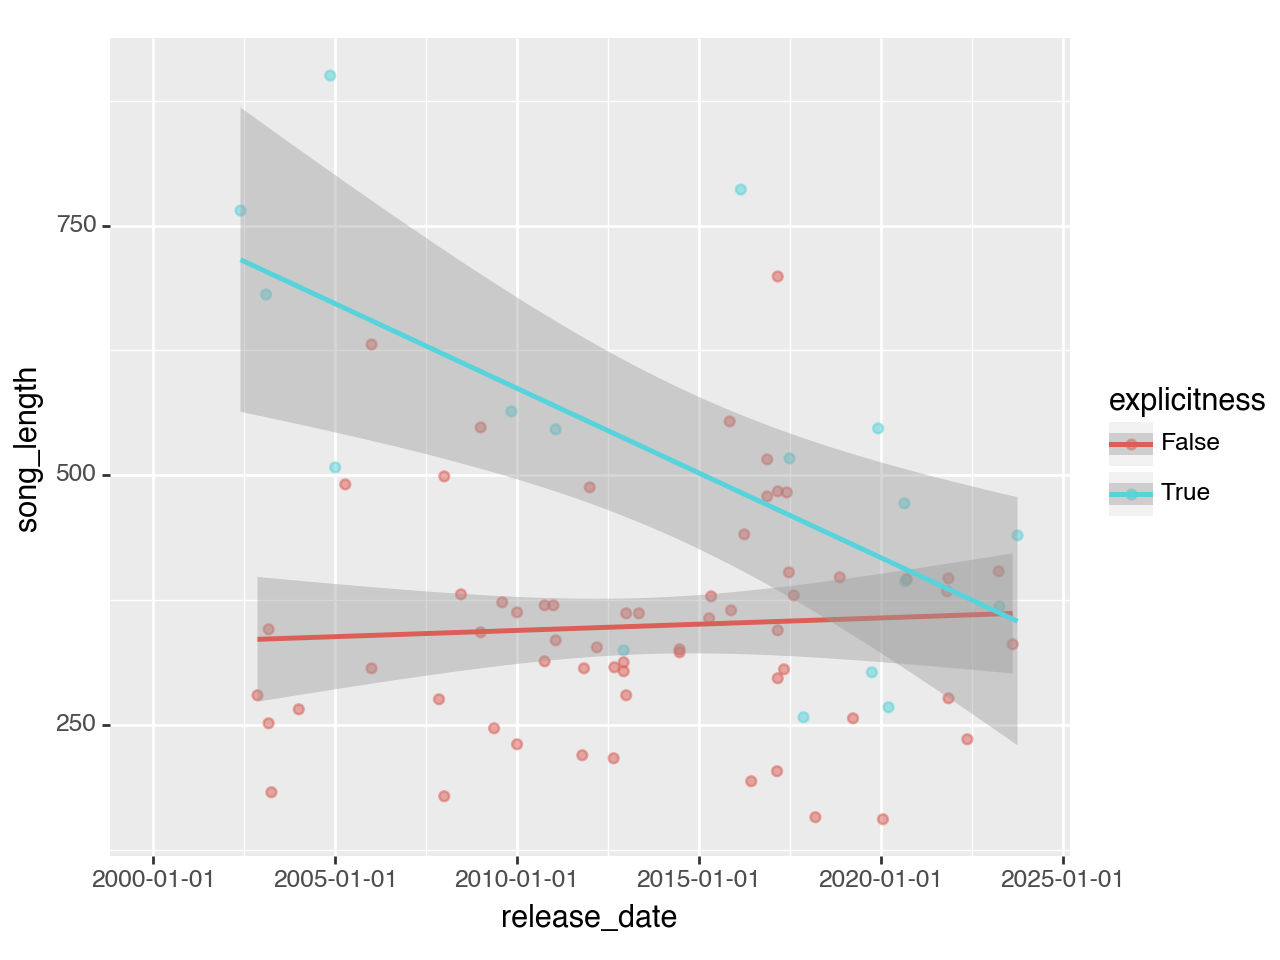

<Figure Size: (640 x 480)>

In [230]:
line = (
    ggplot(df) +
    aes(x = 'release_date', y = 'song_length', colour = 'explicitness') +
    geom_point(alpha = 0.5) +
    geom_smooth(method = "lm") +
    scale_x_datetime(
        limits=(datetime(2000, 1, 1), datetime(2024, 1, 1)),
    )
)

line

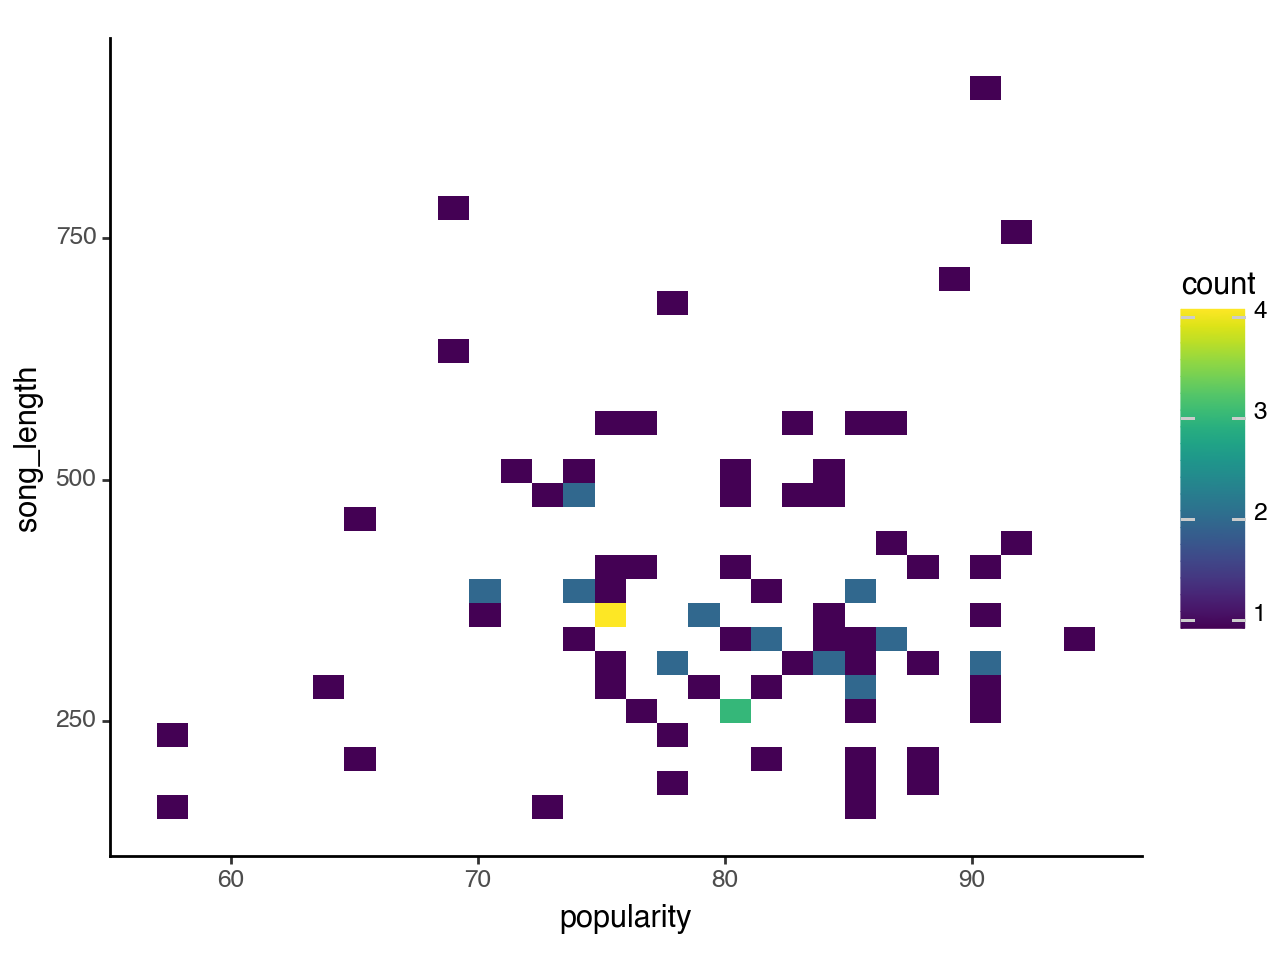

<Figure Size: (640 x 480)>

In [231]:
contour = (
    ggplot(df) +
    aes(x = 'popularity', y = 'song_length') +
    geom_bin2d() +
    theme_classic()
)

contour

In [235]:
contour = (
    ggplot(df) +
    aes(x = 'lexical_richness', y = 'sentiment_compound', z = 'popularity') +
    geom_contour_filled(aes(fill = 'level') +
    geom_contour(colour = 'black'))
)

contour

NameError: name 'geom_contour_filled' is not defined

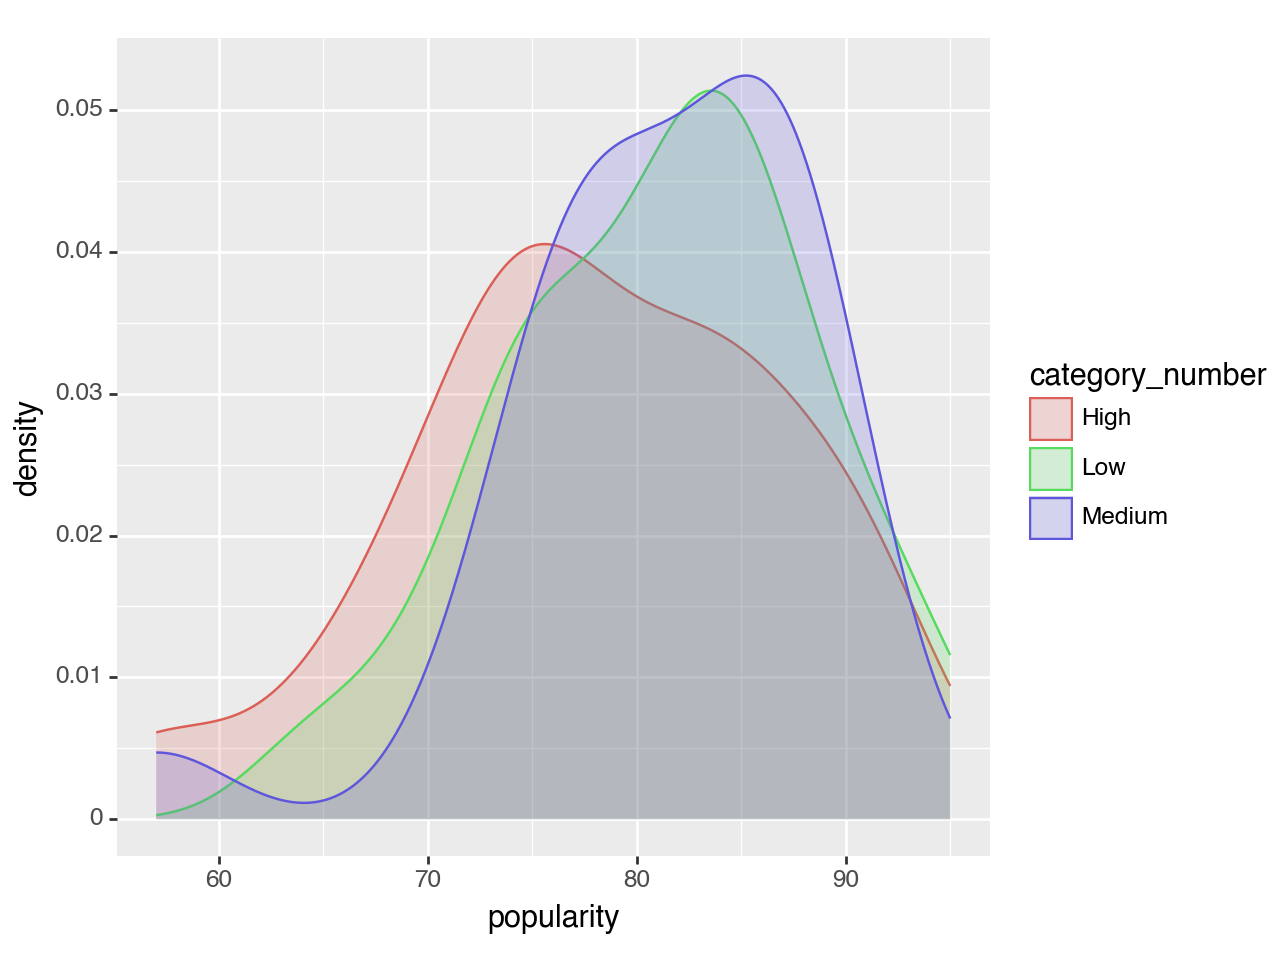

<Figure Size: (640 x 480)>

In [210]:
distribution = (
    ggplot(df) +
    aes(x = 'popularity', colour = 'category_number', fill = 'category_number') +
    geom_density(alpha = 0.2)
)

distribution

In [236]:
%load_ext rpy2.ipython

In [238]:
%%R

plot = (
    ggplot(df, aes(x='lexical_richness', y='sentiment_compound', z='popularity')) +
    geom_contour_filled(aes(fill='..level..')) +
    geom_contour(color='black') +
    scale_fill_cmap(name='viridis')
)

Error in ggplot(df, aes(x = "lexical_richness", y = "sentiment_compound",  : 
  could not find function "ggplot"


RInterpreterError: Failed to parse and evaluate line "\nplot = (\n    ggplot(df, aes(x='lexical_richness', y='sentiment_compound', z='popularity')) +\n    geom_contour_filled(aes(fill='..level..')) +\n    geom_contour(color='black') +\n    scale_fill_cmap(name='viridis')\n)\n".
R error message: 'Error in ggplot(df, aes(x = "lexical_richness", y = "sentiment_compound",  : \n  could not find function "ggplot"'